### Linear Regression - Banking Sharing Company 
Predicting the demand for sharing bikes company to increase the revenue of the company:

1. Exploratory Data Analysis (EDA)
2. Correlation, linearity assumptions and multicollinearity checks
3. Feature selection
4. Train/ test/ eval split
5. Model Building 
6. Model Evaluation 
7. Interpretation - Business Translation

##### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Hypothesis testing packages
from scipy.stats import f_oneway

### Modelling packages
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.metrics import r2_score

### For displaying the tables
from IPython.display import display


In [2]:
data=pd.read_csv('day.csv')
display(data.head(5))
display(data.info())
data.shape

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


None

(730, 16)

In [3]:
data['dteday']=pd.to_datetime(data['dteday'])

The **target variable** here should be **cnt** which is the sum of casual and registered members of the company.

### 1. Exploratory Data Analysis & Data pre-processing

* Categorical data visulaization to check the relationship of predictors with target varaible **"cnt"**
* Detecting outliers in the data
* Checking for multicollinearity 
* Linearity of output and input variables assumption - Check

,yr,mnth,casual,registered,cnt,casual_prop,registered_prop
0,0,1,3073,35116,38189,0.080468,0.919532
1,0,2,6242,41973,48215,0.129462,0.870538
2,0,3,12826,51219,64045,0.200265,0.799735
3,0,4,22346,72524,94870,0.235543,0.764457
4,0,5,31050,104771,135821,0.228610,0.771390


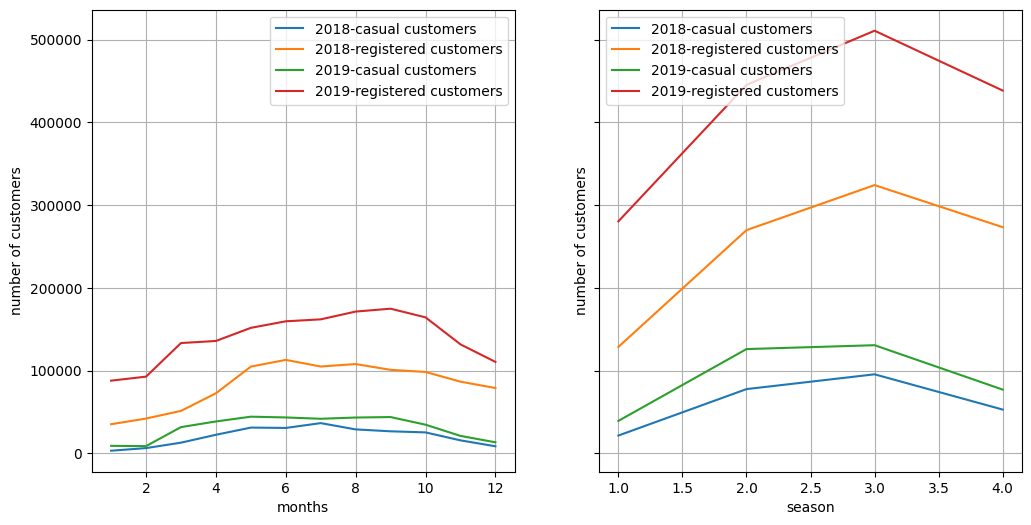

In [4]:
### Categorical varaibles and target varaible
fig, ax= plt.subplots(1,2,figsize=(12,6), sharey=True)

yr_mnth_db=data.groupby(['yr','mnth']).agg({'casual':'sum','registered':'sum','cnt':'sum'}).reset_index()
yr_mnth_db['casual_prop']=yr_mnth_db['casual']/yr_mnth_db['cnt']
yr_mnth_db['registered_prop']=yr_mnth_db['registered']/yr_mnth_db['cnt']
display(yr_mnth_db.head())

### Plotting the graphs
for i,j in zip(yr_mnth_db.yr.unique(),('2018','2019')):
    db=yr_mnth_db[yr_mnth_db['yr']==i]
    ax[0].plot(db.mnth,db.casual,label=f'{j}-casual customers')
    ax[0].plot(db.mnth,db.registered,label=f'{j}-registered customers')
    ax[0].set_xlabel('months')
    ax[0].set_ylabel('number of customers')
    ax[0].legend()
ax[0].grid()
db2=data.groupby(['season','yr']).agg({'casual':'sum','registered':'sum','cnt':'sum'}).reset_index()
for i,j in zip(yr_mnth_db.yr.unique(),('2018','2019')):
    db=db2[db2['yr']==i]
    ax[1].plot(db.season,db.casual,label=f'{j}-casual customers')
    ax[1].plot(db.season,db.registered,label=f'{j}-registered customers')
    ax[1].set_xlabel('season')
    ax[1].set_ylabel('number of customers')
    ax[1].legend()
ax[1].grid()

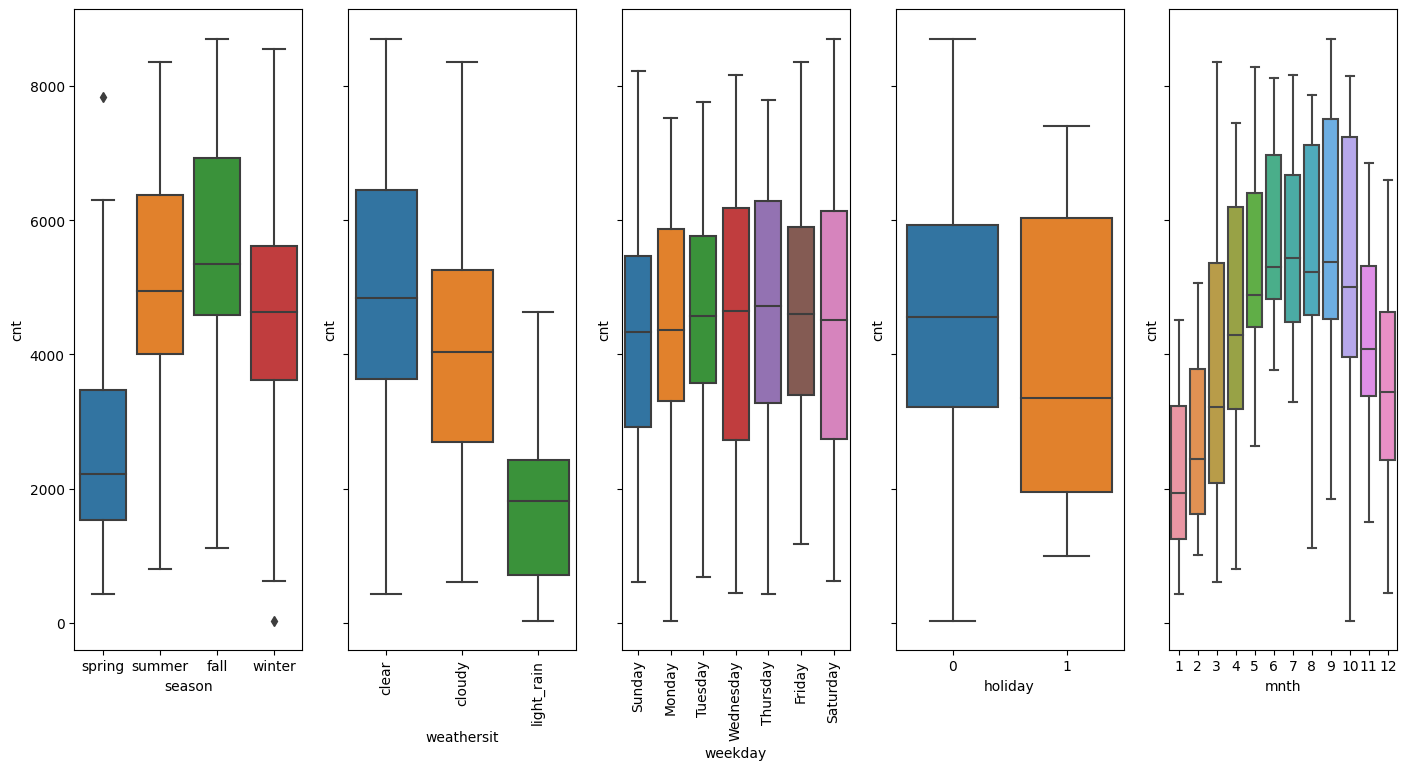

In [5]:
fig, ax= plt.subplots(1,5,figsize=(14,7),sharey=True)
fig.tight_layout()
sns.boxplot(data, x='season',y='cnt',ax=ax[0])
sns.boxplot(data, x='weathersit',y='cnt',ax=ax[1])
sns.boxplot(data, x='weekday',y='cnt',ax=ax[2])
sns.boxplot(data, x='holiday',y='cnt',ax=ax[3])
sns.boxplot(data, x='mnth',y='cnt',ax=ax[4])
ax[0].set_xticks(range(data.season.nunique()),('spring','summer','fall','winter'))
ax[1].set_xticks(range(data.weathersit.nunique()),("clear","cloudy","light_rain"),rotation=90)
ax[2].set_xticks(range(data.weekday.nunique()),("Sunday","Monday","Tuesday", "Wednesday", "Thursday","Friday","Saturday"),rotation=90)

plt.show()

#### Hypothesis testing

$H_0$: The subgroups of categorical variable has no significant relationship with the target variable 

$H_1$: The subgroups of categorical variable has significant relationship with the target variable 

With the level of significance ($\alpha$): 5%

In [6]:
### Let's test the significance of groups in response to the target variable
for i in ('season','weathersit','weekday','holiday','mnth'):
    print(f'{i}- One-way ANOVA test')
    groups=[data['cnt'][data[f'{i}']==j] for j in data[i].unique()]
    # print(groups)
    f_stats, p_value = f_oneway(*groups)
    if p_value<0.05:
        print(f'p value: {p_value:.4f} is much lesser than 0.05. Hence there is a significant difference between the sub-groups of {i} and the target variable cnt')
    else:
        print(f'p value: {p_value:.4f} is greater than 0.05. Hence there is no significant difference between the sub-groups of {i} and the target variable cnt or we fail to reject the null hypothesis')  

season- One-way ANOVA test
p value: 0.0000 is much lesser than 0.05. Hence there is a significant difference between the sub-groups of season and the target variable cnt
weathersit- One-way ANOVA test
p value: 0.0000 is much lesser than 0.05. Hence there is a significant difference between the sub-groups of weathersit and the target variable cnt
weekday- One-way ANOVA test
p value: 0.5722 is greater than 0.05. Hence there is no significant difference between the sub-groups of weekday and the target variable cnt or we fail to reject the null hypothesis
holiday- One-way ANOVA test
p value: 0.0633 is greater than 0.05. Hence there is no significant difference between the sub-groups of holiday and the target variable cnt or we fail to reject the null hypothesis
mnth- One-way ANOVA test
p value: 0.0000 is much lesser than 0.05. Hence there is a significant difference between the sub-groups of mnth and the target variable cnt


Looking at the significance of the subgrpoups with the target variable. Let's start creating dummy variable to treat each of them as a feature input. The variable holiday is slightly higher than the 5%. That's quite a borderline. So keeping them for feature selection process. 

Visually, the boxplot graphs & one-way ANOVA test has proved that there's a significance difference between these sub-groups of season, weathersit,months, holiday (except weekday) the seem very significant to target variable

Mapping the categorical variables and pre-processing them for modelling

In [7]:
data['season_cat']=data['season'].map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})
data['weekday_cat']=data['weekday'].map({1:"Monday",2:"Tuesday", 3: "Wednesday", 4: "Thursday",5: "Friday",6: "Saturday",7:"Sunday"})
data['weathersit_cat']=data['weathersit'].map({1:"clear",2:"cloudy",3:"light_rain",4:"heavy_rain"})
data['mnth_cat']=data['mnth'].map({1: "January",2: "February",3: "March",4: "April",5: "May",6: "June",7: "July",8: "August",9: "September",10: "October",11: "November",12: "December"})
data['season_cat'].value_counts(), data['weekday_cat'].value_counts(),data['weathersit_cat'].value_counts()

(fall      188
 summer    184
 spring    180
 winter    178
 Name: season_cat, dtype: int64,
 Saturday     105
 Monday       105
 Tuesday      104
 Thursday     104
 Friday       104
 Wednesday    103
 Name: weekday_cat, dtype: int64,
 clear         463
 cloudy        246
 light_rain     21
 Name: weathersit_cat, dtype: int64)

In [8]:
columns={'season':'season_cat','weekday':'weekday_cat','weathersit':'weathersit_cat','mnth':'mnth_cat'}
for key,cols in columns.items():
    colss=pd.get_dummies(data[cols],prefix=key,drop_first=True)
    data=pd.concat([data,colss],axis=1)
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,mnth_December,mnth_February,mnth_January,mnth_July,mnth_June,mnth_March,mnth_May,mnth_November,mnth_October,mnth_September
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,...,0,0,1,0,0,0,0,0,0,0
1,2,2018-02-01,1,0,1,0,0,0,2,14.902598,...,0,0,1,0,0,0,0,0,0,0
2,3,2018-03-01,1,0,1,0,1,1,1,8.050924,...,0,0,1,0,0,0,0,0,0,0
3,4,2018-04-01,1,0,1,0,2,1,1,8.200000,...,0,0,1,0,0,0,0,0,0,0
4,5,2018-05-01,1,0,1,0,3,1,1,9.305237,...,0,0,1,0,0,0,0,0,0,0


<AxesSubplot:>

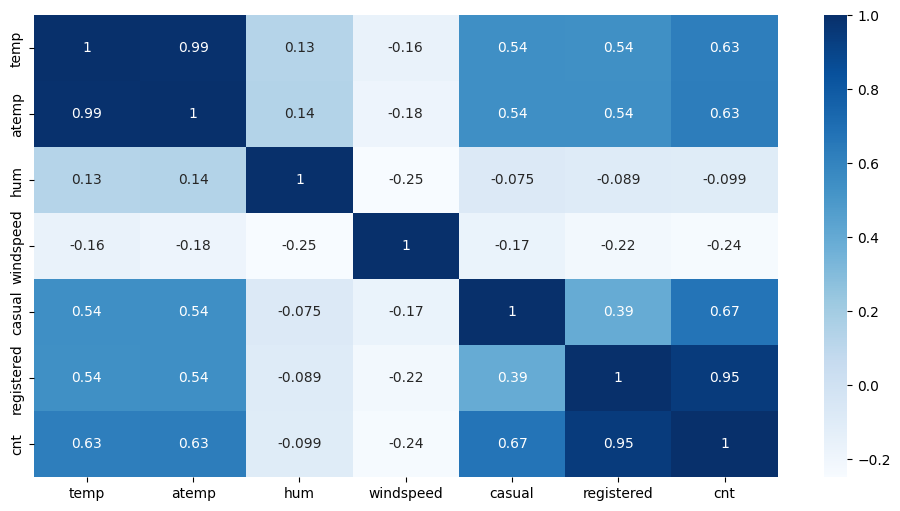

In [9]:
#### Numerical Variables - Correlation matrix 
plt.subplots(figsize=(12,6))
sns.heatmap(data[['temp', 'atemp', 'hum', 'windspeed', 'casual','registered', 'cnt']].corr(),cmap='Blues',annot=True)

Having said that, **cnt** is the target variable. Correlation of cnt with the following variables and it's relevance to be added 
* temp has positive correlation of 63% - Adding this variable as a feature would explain the variability of target variable
* atemp and temp seems to have higly correlated - Might fail the no-multicollinearity assumption of LR - recommended not to add
* windspeed and humidity are negatively correlated - Although the relationship is weaker, there is no harm in adding it as features
* **Casual and registered are highly correlated with 67% and 95%**. However, this is deterministic as the **cnt** is the sum of those two variables. Ideally, we should not consider these two variables as feature input due to **data leakage issues (using parts of output as input is malicious for the model accuracy)**

Let's confirm the same with variance inflation factor (VIF)

In [10]:
# the independent variables set
feat=['season_spring', 'season_summer', 'season_winter',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weathersit_cloudy',
       'weathersit_light_rain','yr', 'mnth_August',
       'mnth_December', 'mnth_February', 'mnth_January', 'mnth_July',
       'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October',
       'mnth_September', 'holiday',
       'workingday', 'temp','atemp', 'hum', 'windspeed']
for i in range(100):
    X = data[feat]
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = feat

    # calculating VIF for each feature
    vif_data["VIF"] = [VIF(X.values, i) for i in range(len(feat))]
    ### VIF threshold is 10 
    if (vif_data["VIF"].max()>5):
        # display(vif_data)
        rm_val=feat.pop(np.argmax(vif_data["VIF"]))
        print(f'Iter: {i+1}; Removed feature:{rm_val} ({vif_data["VIF"].max():.2f}) & Next_list: {feat}\n')
    else:
        print(f'Features set with no multicollinearity: {feat}')
        display(vif_data)
        break  

Iter: 1; Removed feature:temp (673.09) & Next_list: ['season_spring', 'season_summer', 'season_winter', 'weekday_Monday', 'weekday_Saturday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'weathersit_cloudy', 'weathersit_light_rain', 'yr', 'mnth_August', 'mnth_December', 'mnth_February', 'mnth_January', 'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October', 'mnth_September', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed']

Iter: 2; Removed feature:atemp (43.00) & Next_list: ['season_spring', 'season_summer', 'season_winter', 'weekday_Monday', 'weekday_Saturday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'weathersit_cloudy', 'weathersit_light_rain', 'yr', 'mnth_August', 'mnth_December', 'mnth_February', 'mnth_January', 'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October', 'mnth_September', 'holiday', 'workingday', 'hum', 'windspeed']

Iter: 3; Removed feature:hum (26.11) & Next_list: ['sea

,feature,VIF
0,season_summer,2.581528
1,weekday_Monday,1.573594
2,weekday_Saturday,1.467234
3,weekday_Thursday,1.462196
4,weekday_Tuesday,1.466474
5,weekday_Wednesday,1.483292
6,weathersit_cloudy,1.585112
7,weathersit_light_rain,1.095425
8,yr,1.962815
9,mnth_August,1.317113


Using VIF, variables with high VIF (>5) are removed and the final set of features are ['season_spring', 'season_summer', 'season_winter', 'weekday_Monday', 'weekday_Saturday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'weathersit_cloudy', 'weathersit_light_rain', 'yr', 'holiday', 'temp'] are the major drivers of demand in 


#### Feature selection

1. Rescaling or standardizing the features set
2. Train the model
3. Check for Bias and Variance of the model fitted
4. Predictions and evaluation on test data & Interpretations


In [11]:
features=['season_spring', 'season_summer', 'season_winter',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weathersit_cloudy',
       'weathersit_light_rain','yr', 'mnth_August',
       'mnth_December', 'mnth_February', 'mnth_January', 'mnth_July',
       'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October',
       'mnth_September', 'holiday',
       'workingday', 'temp','atemp', 'hum', 'windspeed','cnt']

### Splitting for train and test variables
df_train,df_test=train_test_split(data[features], train_size=0.70,random_state=100)

### Rescaling-Standardizing 
Scaler= MinMaxScaler()
cols=['temp','atemp', 'hum', 'windspeed','cnt']

df_train[cols]=Scaler.fit_transform(df_train[cols])
print('Normalized X train:')
display(df_train.head())
display(df_train.describe())

df_test[cols]=Scaler.transform(df_test[cols])
# print('\nNormalized X test:')
display(df_test.head())
display(df_test.describe())


Normalized X train:


,season_spring,season_summer,season_winter,weekday_Monday,weekday_Saturday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_cloudy,weathersit_light_rain,...,mnth_November,mnth_October,mnth_September,holiday,workingday,temp,atemp,hum,windspeed,cnt
576,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0.815169,0.766351,0.725633,0.264686,0.827658
426,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0.442393,0.438975,0.640189,0.255342,0.465255
728,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.245101,0.200348,0.498067,0.663106,0.204096
482,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0.395666,0.391735,0.504508,0.188475,0.482973
111,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095


,season_spring,season_summer,season_winter,weekday_Monday,weekday_Saturday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_cloudy,weathersit_light_rain,...,mnth_November,mnth_October,mnth_September,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.243137,0.247059,0.247059,0.150980,0.154902,0.133333,0.131373,0.158824,0.345098,0.029412,...,0.086275,0.084314,0.080392,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499
std,0.429398,0.431725,0.431725,0.358381,0.362166,0.340268,0.338139,0.365870,0.475867,0.169124,...,0.281045,0.278131,0.272166,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,season_spring,season_summer,season_winter,weekday_Monday,weekday_Saturday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_cloudy,weathersit_light_rain,...,mnth_November,mnth_October,mnth_September,holiday,workingday,temp,atemp,hum,windspeed,cnt
184,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706
535,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0.901354,0.842587,0.610133,0.153728,0.712034
299,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382
221,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400
152,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029


,season_spring,season_summer,season_winter,weekday_Monday,weekday_Saturday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_cloudy,weathersit_light_rain,...,mnth_November,mnth_October,mnth_September,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.254545,0.263636,0.236364,0.127273,0.118182,0.163636,0.168182,0.100000,0.318182,0.027273,...,0.072727,0.086364,0.086364,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154
std,0.436599,0.441609,0.425817,0.334038,0.323559,0.370789,0.374881,0.300684,0.466833,0.163248,...,0.260281,0.281541,0.281541,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300


Selecting features using backward selection and VIF method

In [12]:
features = ['season_spring', 'season_summer', 'season_winter', 'weathersit_cloudy',
       'weathersit_light_rain','yr', 'mnth_August',
       'mnth_December', 'mnth_February', 'mnth_January', 'mnth_July',
       'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October',
       'mnth_September', 'holiday','temp', 'hum', 'windspeed']
model_metrics=pd.DataFrame()
vif_data = pd.DataFrame()
feats=[]
for i in range(100):
    Y_train=df_train['cnt']
    X_train=df_train[features]
    
    
    Y_test=df_test['cnt']
    X_test=df_test[features]
    
    c_sm=sm.add_constant(X_train)
    lm=sm.OLS(Y_train,c_sm)
    model=lm.fit()
    
    c_sm_test=sm.add_constant(X_test)
    y_pred=model.predict(c_sm_test)
    rscore=r2_score(Y_test,y_pred)
    
    
    # vif_data["feature"] = features
    X=pd.concat([df_train[features],df_test[features]])
    # calculating VIF for each feature
    vif = [VIF(X.values, i) for i in range(len(features))]
    db=pd.DataFrame({'features':features, 'vif':vif}).assign(Model=i+1)
    vif_data=pd.concat([vif_data,db],axis=0)
    
    tb=pd.DataFrame({'features':list(model.pvalues.index),'p-value':model.pvalues.values}).assign(Model=i+1,rsquared=model.rsquared,adj_rsquared=model.rsquared_adj,pred_r2score=rscore)
    model_metrics=pd.concat([model_metrics,tb])
    # print(model.summary())
    
    if model.pvalues.max()>0.05:
        # print(model.pvalues.max())
        to_remove_feature=np.argmax(model.pvalues)-1
        # print(to_remove_feature)
        print(f'Removing {model.pvalues.index[np.argmax(model.pvalues)]} due to its statistical insignificance')
        features.pop(to_remove_feature)
        print(f'Next iteration features set:{features}')
    else:
        print(f'Final Model {i+1} with R-squared and Adjusted R-squared with only statistically significant variables:{model.rsquared} & {model.rsquared_adj} respectively \n')
        print(f'The final set of features with only statistically significant variables to predict number of rentals: {features}')
        break
    model_met=model_metrics.merge(vif_data,how='left',on=['Model','features']).dropna()
    
#### Calculating delta -- To choose the best model 
#### The delta is the difference between adjusted r-squared and predicted r-squared
model_met['delta']=abs(model_met.adj_rsquared-model_met.pred_r2score)
# print(np.argmin(model_met.delta))
model_met[model_met['delta']==model_met.delta.min()]
display(model_met.dropna())


Removing mnth_June due to its statistical insignificance
Next iteration features set:['season_spring', 'season_summer', 'season_winter', 'weathersit_cloudy', 'weathersit_light_rain', 'yr', 'mnth_August', 'mnth_December', 'mnth_February', 'mnth_January', 'mnth_July', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October', 'mnth_September', 'holiday', 'temp', 'hum', 'windspeed']
Removing mnth_October due to its statistical insignificance
Next iteration features set:['season_spring', 'season_summer', 'season_winter', 'weathersit_cloudy', 'weathersit_light_rain', 'yr', 'mnth_August', 'mnth_December', 'mnth_February', 'mnth_January', 'mnth_July', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_September', 'holiday', 'temp', 'hum', 'windspeed']
Removing mnth_March due to its statistical insignificance
Next iteration features set:['season_spring', 'season_summer', 'season_winter', 'weathersit_cloudy', 'weathersit_light_rain', 'yr', 'mnth_August', 'mnth_December', 'mnth_February', 'mnth_Ja

,features,p-value,Model,rsquared,adj_rsquared,pred_r2score,vif,delta
1,season_spring,1.424299e-01,1,0.846489,0.839883,0.823849,11.584878,0.016034
2,season_summer,9.295817e-02,1,0.846489,0.839883,0.823849,6.464387,0.016034
3,season_winter,1.678603e-04,1,0.846489,0.839883,0.823849,10.305449,0.016034
4,weathersit_cloudy,2.742693e-07,1,0.846489,0.839883,0.823849,2.362402,0.016034
5,weathersit_light_rain,7.480460e-19,1,0.846489,0.839883,0.823849,1.322356,0.016034
...,...,...,...,...,...,...,...,...
112,mnth_September,1.466600e-05,6,0.845766,0.840760,0.824434,1.451372,0.016327
113,holiday,5.838024e-04,6,0.845766,0.840760,0.824434,1.041968,0.016327
114,temp,4.736553e-30,6,0.845766,0.840760,0.824434,17.959747,0.016327
115,hum,2.648526e-05,6,0.845766,0.840760,0.824434,30.351975,0.016327


Based on the predicted r^2 value, we conclude the features set of Model 5


,features,p-value,Model,rsquared,adj_rsquared,pred_r2score,vif,delta
93,mnth_May,2.015659e-01,5,0.846277,0.840965,0.825953,1.549997,0.015012
90,mnth_February,8.991545e-02,5,0.846277,0.840965,0.825953,2.133163,0.015012
84,season_summer,8.675003e-02,5,0.846277,0.840965,0.825953,3.338094,0.015012
94,mnth_November,1.811099e-02,5,0.846277,0.840965,0.825953,1.819644,0.015012
83,season_spring,1.328141e-02,5,0.846277,0.840965,0.825953,5.758052,0.015012
89,mnth_December,1.273729e-02,5,0.846277,0.840965,0.825953,1.696481,0.015012
92,mnth_July,3.272911e-03,5,0.846277,0.840965,0.825953,1.714011,0.015012
91,mnth_January,3.082004e-03,5,0.846277,0.840965,0.825953,2.376934,0.015012
96,holiday,6.500080e-04,5,0.846277,0.840965,0.825953,1.042402,0.015012
98,hum,1.508420e-05,5,0.846277,0.840965,0.825953,30.412828,0.015012


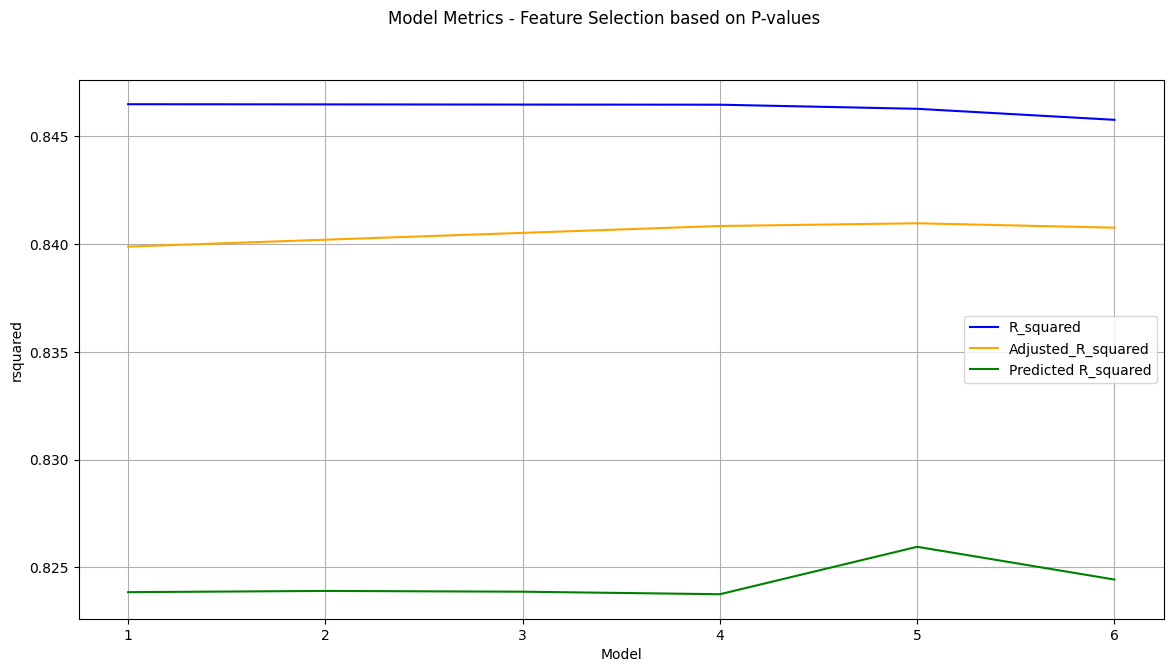

In [13]:
### Visualization of the models built & choosing the best model

fig, ax=plt.subplots(figsize=(14,7),sharey=True)

subdata=model_met.groupby(['Model']).agg({'rsquared':'min','adj_rsquared':'min','pred_r2score':'min'}).reset_index()
fig.suptitle('Model Metrics - Feature Selection based on P-values')
l1=sns.lineplot(data=subdata, x="Model", y="rsquared",color='blue',label='R_squared',)
l2=sns.lineplot(data=subdata, x="Model", y="adj_rsquared",color='orange',label='Adjusted_R_squared')
l3=sns.lineplot(data=subdata, x="Model", y="pred_r2score",color='green',label='Predicted R_squared')
# ax[0].set_ylabel('model_metrics')
ax.legend()
ax.grid()
print(f'Based on the predicted r^2 value, we conclude the features set of Model {subdata["Model"][np.argmax(subdata.pred_r2score)]}')
display(model_met[model_met['Model']==subdata["Model"][np.argmax(subdata.pred_r2score)]].sort_values('p-value',ascending=False))

I have chosen the model 6 with highest predicted r-squared value. 
Most important, point to be noted is that **temp, hum & windspeed seems to have highest VIFs (>5)**. However **removing those variables is significantly impacting the fit of the model**. So, it is important to keep those varaible in the model.

Some were insignificant and however removing caused a decline in the successive models. Hence, keeping them despite the high p-value variables. The compounding effect of them has some significance in the model model performance

### Final model building & evaluation on test with the selected set of features

Splitting the data as train and test on different random states to test the variability of the model. This is to assure the model stability.

In [14]:
### Final Model building with retrians
final_feats =model_met[model_met['Model']==subdata["Model"][np.argmax(subdata.pred_r2score)]]['features'].to_list()
print(f'final features going into the model: {final_feats}')
print(f'Total number of features: {len(final_feats)}')
final_model_metrics=pd.DataFrame()
def adj_r2_score(r2=0.3,n=1,p=2):
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2
    

for i,j in zip(range(111,131),range(len(range(111,131)))):
    Scaler= MinMaxScaler()
    cols=['temp','atemp', 'hum', 'windspeed','cnt']
    
    df_train,df_test=train_test_split(data, train_size=0.70,random_state=i)

    ### Rescaling-Standardizing 
    Scaler= MinMaxScaler()
    cols=['temp','atemp', 'hum', 'windspeed','cnt']

    df_train[cols]=Scaler.fit_transform(df_train[cols])
    df_test[cols]=Scaler.transform(df_test[cols])
    
        
    X_train,X_test,Y_train,Y_test=df_train[final_feats],df_test[final_feats],df_train['cnt'],df_test['cnt']
    
    lm=LinearRegression()
    
    model=lm.fit(X_train,Y_train)
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    r2_score_train=r2_score(Y_train,y_train_pred)
    r2_score_test=r2_score(Y_test,y_test_pred)
    adj_r2_train=adj_r2_score(r2_score_train,n=X_train.shape[0],p=X_train.shape[1])
    adj_r2_test=adj_r2_score(r2_score_test,n=X_test.shape[0],p=X_test.shape[1])
    dets={'Rounds':[f'Round_{j+1}'],'r2_score_train':[r2_score_train],'r2_score_test':[r2_score_test],'adj_r2_train':[adj_r2_train],'adj_r2_test':[adj_r2_test]}
    db=pd.DataFrame(dets)
    final_model_metrics=pd.concat([final_model_metrics,db])
    
display(final_model_metrics)
print(f'The average R-squared score on train set:{final_model_metrics.r2_score_train.mean()*100:.2f}%')
print(f'The average Adjusted R-squared score on train set:{final_model_metrics.adj_r2_train.mean()*100:.2f}%')
print(f'The average R-squared score on test set:{final_model_metrics.r2_score_test.mean()*100:.2f}%\n')
coeff_feat_df=pd.DataFrame({'features':final_feats,'coefficients':model.coef_}).sort_values('coefficients',ascending=False).reset_index()
print('Highest +ve contributing features')
display(coeff_feat_df.head())
print('Highest -ve contributing features')
display(coeff_feat_df.tail())

final features going into the model: ['season_spring', 'season_summer', 'season_winter', 'weathersit_cloudy', 'weathersit_light_rain', 'yr', 'mnth_December', 'mnth_February', 'mnth_January', 'mnth_July', 'mnth_May', 'mnth_November', 'mnth_September', 'holiday', 'temp', 'hum', 'windspeed']
Total number of features: 17


,Rounds,r2_score_train,r2_score_test,adj_r2_train,adj_r2_test
0,Round_1,0.853506,0.814092,0.848444,0.798446
0,Round_2,0.860126,0.789699,0.855293,0.772001
0,Round_3,0.854050,0.808921,0.849007,0.792840
0,Round_4,0.844817,0.832913,0.839455,0.818852
0,Round_5,0.851723,0.817249,0.846599,0.801869
0,Round_6,0.834663,0.853071,0.828950,0.840706
0,Round_7,0.846054,0.826054,0.840735,0.811415
0,Round_8,0.835758,0.855431,0.830083,0.843264
0,Round_9,0.844417,0.831376,0.839041,0.817185
0,Round_10,0.842084,0.837437,0.836628,0.823756


The average R-squared score on train set:84.69%
The average Adjusted R-squared score on train set:84.16%
The average R-squared score on test set:82.45%

Highest +ve contributing features


,index,features,coefficients
0,14,temp,0.416215
1,5,yr,0.239976
2,2,season_winter,0.112853
3,12,mnth_September,0.051725
4,1,season_summer,0.027800


Highest -ve contributing features


,index,features,coefficients
12,6,mnth_December,-0.081075
13,8,mnth_January,-0.090583
14,16,windspeed,-0.161451
15,15,hum,-0.165587
16,4,weathersit_light_rain,-0.274079


The final fit of the model has R-squared & Ajusted R-squared score of 84.73% and 84.17% respectively The performance on the evaluation set is also as good as seen in the training set (82.42%). The delta is just 2% which is not a significant delta to be called as a over-fitted model. Hence, the selected varaibles are good fit for the explainability of the model. 

### Residual Analysis

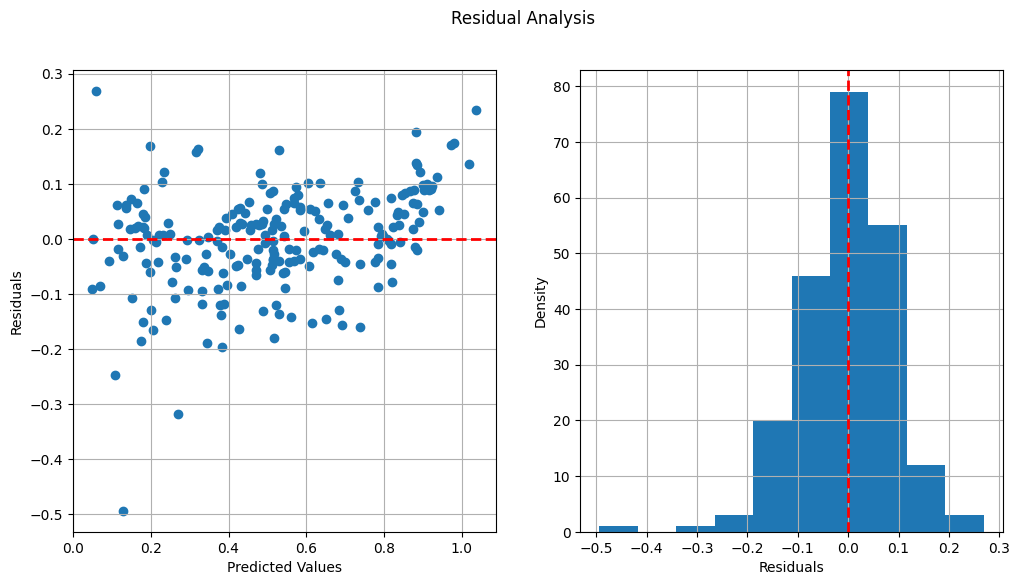

In [15]:
fig, ax=plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Residual Analysis')

### 
ax[0].scatter(Y_test,Y_test-y_test_pred)
ax[0].axhline(0, color='red', linestyle='--', linewidth=2)
ax[0].set_xlabel("Predicted Values")
ax[0].set_ylabel("Residuals")
ax[0].grid()

### homoscedasticity test 
ax[1].hist(Y_test-y_test_pred)
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Density')
ax[1].axvline(0, color='red', linestyle='--', linewidth=2)
ax[1].grid()

# sns.kdeplot(Y_test-y_test_pred)


* The first plot shows that, there's no pattern in the plotted residuals. This holds homoscedasticity condition of linearity assumption
* The second plot shows that, the residuals are normally distributed with mean and std deviation 1.
* Less Multi-collinearity condition is also met through our feature selection process. We decided to keep certain variables like temperature, humidity and windspeed due to their statistical significance. Some high p-value are still kept as the predicted r-squared values were close to adjusted r_squared value

In [16]:
############ By Abbhiraami S ##############